In [1]:
import importlib.util
from pathlib import Path

# define paths to files
data_loader_path = Path.cwd().parent / "src" / "data_loader.py"
classical_model_path = Path.cwd().parent / "src" / "classical_model.py"

# load them directly
spec = importlib.util.spec_from_file_location("data_loader", data_loader_path)
data_loader = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_loader)

spec = importlib.util.spec_from_file_location("classical_model", classical_model_path)
classical_model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(classical_model)

# extract
create_dataloaders = data_loader.create_dataloaders
M87FlareDataset = data_loader.M87FlareDataset
CNNAutoencoder = classical_model.CNNAutoencoder
create_optimizer = classical_model.create_optimizer
create_loss_function = classical_model.create_loss_function

print("✓ All imports loaded via absolute paths")

✓ All imports loaded via absolute paths


In [2]:
# setup and path
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score
import torch  # FIXED: was "import pytorch as torch"

# Add project root to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
sys.path.insert(0, str(src_path))

print(f"[SETUP] Project root: {project_root}")
print(f"[SETUP] Added to sys.path: {src_path}")
print(f"[SETUP] src/ exists: {src_path.exists()}")

# import modules
try:
    from data_loader import create_dataloaders, M87FlareDataset
    from classical_model import CNNAutoencoder, create_optimizer, create_loss_function
    print("All imports successful")
except ImportError as e:
    print(f"Import error: {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)

# set seeds
torch.manual_seed(67)
np.random.seed(67)
print(f"[SETUP] Random seeds set")

[SETUP] Project root: c:\Users\Salman\Desktop\qae-eht-m87-flares
[SETUP] Added to sys.path: c:\Users\Salman\Desktop\qae-eht-m87-flares\src
[SETUP] src/ exists: True
All imports successful
[SETUP] Random seeds set


In [3]:
# split validation
print("\n" + "="*60)
print("CRITICAL: VALIDATING ANOMALY DETECTION SPLITS")
print("="*60)

# re-declare in case of kernel restart
data_dir = Path("../data/processed")

train_loader, val_loader, test_loader = create_dataloaders(
    data_dir=str(data_dir),  # Convert Path to string
    batch_size=32,
    num_workers=2
)

# check train set (must be 100% normal)
train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.numpy())
train_labels = np.array(train_labels)

# check val set (must be 100% normal)
val_labels = []
for _, labels in val_loader:
    val_labels.extend(labels.numpy())
val_labels = np.array(val_labels)

# check test set (should have both)
test_labels = []
for _, labels in test_loader:
    test_labels.extend(labels.numpy())
test_labels = np.array(test_labels)

print(f"[TRAIN] Total: {len(train_labels)}, Flares: {(train_labels == 1).sum()}")
print(f"[VAL] Total: {len(val_labels)}, Flares: {(val_labels == 1).sum()}")
print(f"[TEST] Total: {len(test_labels)}, Flares: {(test_labels == 1).sum()}")

# Validation summary
if (train_labels == 1).sum() == 0 and (val_labels == 1).sum() == 0:
    print("\nSUCCESS: Train/Val are pure normal (anomaly detection compliant)")
else:
    print("\nFAILURE: Train/Val contain flares!")


CRITICAL: VALIDATING ANOMALY DETECTION SPLITS
[M87FlareDataset] Loaded 1000 train samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 300 val samples
[M87FlareDataset] Flare count: 0
[M87FlareDataset] Loaded 900 test samples
[M87FlareDataset] Flare count: 200

[SPLIT SUMMARY]
Train: 1000 samples (normal only)
Val:   300 samples (normal only)
Test:  900 samples (normal + flare)
[TRAIN] Total: 1000, Flares: 0
[VAL] Total: 300, Flares: 0
[TEST] Total: 900, Flares: 200

SUCCESS: Train/Val are pure normal (anomaly detection compliant)


In [4]:
# confirm that train/val/test are truly separate
print("\n" + "="*60)
print("VERIFYING NO DATA LEAKAGE")
print("="*60)

# function to extract all file paths from a loader
def get_loader_files(loader):
    files = []
    dataset = loader.dataset
    for item in dataset.file_list:
        files.append(item["path"])
    return set(files)

train_files = get_loader_files(train_loader)
val_files = get_loader_files(val_loader)
test_files = get_loader_files(test_loader)

print(f"Train files: {len(train_files)}")
print(f"Val files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# check for overlaps (should be 0)
train_val_overlap = len(train_files & val_files)
train_test_overlap = len(train_files & test_files)
val_test_overlap = len(val_files & test_files)

print(f"\n[OVERLAP CHECKS]")
print(f"Train ∩ Val: {train_val_overlap} (should be 0)")
print(f"Train ∩ Test: {train_test_overlap} (should be 0)")
print(f"Val ∩ Test: {val_test_overlap} (should be 0)")

# verify flare distribution in test set
test_labels = []
for _, labels in test_loader:
    test_labels.extend(labels.numpy())
test_labels = np.array(test_labels)

print(f"\n[Test Set Distribution]")
print(f"Normal samples: {(test_labels == 0).sum()}")
print(f"Flare samples: {(test_labels == 1).sum()}")
print(f"Total test samples: {len(test_labels)}")

# final safety check
if (train_val_overlap == 0 and 
    train_test_overlap == 0 and 
    val_test_overlap == 0 and
    (test_labels == 0).sum() == 700 and
    (test_labels == 1).sum() == 200):
    
    print("\n VERIFICATION PASSED")
    print(" No data leakage between splits")
    print(" Test set contains 700 normal + 200 flare (as designed)")
else:
    print("\n❌ VERIFICATION FAILED - Fix your splits!")


VERIFYING NO DATA LEAKAGE
Train files: 1000
Val files: 300
Test files: 900

[OVERLAP CHECKS]
Train ∩ Val: 0 (should be 0)
Train ∩ Test: 0 (should be 0)
Val ∩ Test: 0 (should be 0)

[Test Set Distribution]
Normal samples: 700
Flare samples: 200
Total test samples: 900

 VERIFICATION PASSED
 No data leakage between splits
 Test set contains 700 normal + 200 flare (as designed)


In [5]:
# quick debug
model = CNNAutoencoder(latent_dim=64)
dummy = torch.randn(1, 1, 4, 4)
print(f"Input: {dummy.shape}")

# trace layer-by-layer
x = dummy
for name, layer in model.named_modules():
    if name and not list(layer.children()):  # Only leaf layers
        x = layer(x)
        print(f"{name:20s}: {x.shape}")

print(f"\nFinal: {x.shape}")

Input: torch.Size([1, 1, 4, 4])
encoder.0           : torch.Size([1, 32, 4, 4])
encoder.1           : torch.Size([1, 32, 4, 4])
encoder.2           : torch.Size([1, 32, 4, 4])
encoder.3           : torch.Size([1, 32, 2, 2])
encoder.4           : torch.Size([1, 64, 2, 2])
encoder.5           : torch.Size([1, 64, 2, 2])
encoder.6           : torch.Size([1, 64, 2, 2])
encoder.7           : torch.Size([1, 64, 1, 1])
decoder.0           : torch.Size([1, 64, 2, 2])
decoder.1           : torch.Size([1, 64, 2, 2])
decoder.2           : torch.Size([1, 64, 2, 2])
decoder.3           : torch.Size([1, 32, 4, 4])
decoder.4           : torch.Size([1, 32, 4, 4])
decoder.5           : torch.Size([1, 32, 4, 4])
decoder.6           : torch.Size([1, 1, 4, 4])
decoder.7           : torch.Size([1, 1, 4, 4])

Final: torch.Size([1, 1, 4, 4])


In [6]:
# model architecture verification
print("\n" + "="*60)
print("MODEL ARCHITECTURE VERIFICATION")
print("="*60)

model = CNNAutoencoder(latent_dim=64)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[MODEL] Parameters: {total_params:,}")

dummy = torch.randn(1, 1, 4, 4)
reconstructed, latent = model(dummy)

print(f"[MODEL] Input shape: {dummy.shape}")
print(f"[MODEL] Latent shape: {latent.shape}")
print(f"[MODEL] Output shape: {reconstructed.shape}")

# verify shapes
assert reconstructed.shape == dummy.shape, "Shape mismatch!"
assert latent.shape[1] == 64, "Latent dim wrong!"
print("✓ Model I/O shapes correct")


MODEL ARCHITECTURE VERIFICATION
[MODEL] Parameters: 85,185
[MODEL] Input shape: torch.Size([1, 1, 4, 4])
[MODEL] Latent shape: torch.Size([1, 64, 1, 1])
[MODEL] Output shape: torch.Size([1, 1, 4, 4])
✓ Model I/O shapes correct


In [7]:
# reconstruction error test
print("\n" + "="*60)
print("RECONSTRUCTION ERROR TEST")
print("="*60)

# use torch.no_grad() to prevent gradient tracking
all_errors = []
all_labels = []

model.eval()  # ensure model is in evaluation mode

with torch.no_grad():  # prevents gradient computation
    for batch_data, batch_labels in test_loader:
        errors = model.get_reconstruction_error(batch_data)
        all_errors.extend(errors.numpy())  # now safe to call .numpy()
        all_labels.extend(batch_labels.numpy())

all_errors = np.array(all_errors)
all_labels = np.array(all_labels)

# compute statistics
normal_errors = all_errors[all_labels == 0]
flare_errors = all_errors[all_labels == 1]

print(f"[ERROR] Normal samples: {len(normal_errors)}")
print(f"[ERROR] Flare samples: {len(flare_errors)}")

if len(flare_errors) > 0:
    print(f"[ERROR] Normal mean: {normal_errors.mean():.4f}, std: {normal_errors.std():.4f}")
    print(f"[ERROR] Flare mean: {flare_errors.mean():.4f}, std: {flare_errors.std():.4f}")
    
    if flare_errors.mean() > normal_errors.mean():
        print("Flares have higher error (good for detection)")
    else:
        print("Warning: Flares not more anomalous")
else:
    print("No flare samples in test loader - check your splits!")


RECONSTRUCTION ERROR TEST
[ERROR] Normal samples: 700
[ERROR] Flare samples: 200
[ERROR] Normal mean: 0.2029, std: 0.0001
[ERROR] Flare mean: 0.2038, std: 0.0010
Flares have higher error (good for detection)


In [8]:
# gradient flow test
print("\n" + "="*60)
print("GRADIENT FLOW TEST")
print("="*60)

model.train()
optimizer = create_optimizer(model, learning_rate=0.001)
criterion = create_loss_function()

normal_batch = next(iter(train_loader))[0]
reconstructed, _ = model(normal_batch)
loss = criterion(reconstructed, normal_batch)

print(f"[LOSS] Initial: {loss.item():.6f}")

optimizer.zero_grad()
loss.backward()

# check gradients
has_nan = False
has_zero = False
for name, param in model.named_parameters():
    if param.grad is not None:
        if torch.isnan(param.grad).any():
            has_nan = True
        if param.grad.norm() == 0:
            has_zero = True

if not has_nan and not has_zero:
    print("Gradients flowing correctly")
else:
    print("Gradient issues detected")

optimizer.step()

# verify loss changed
with torch.no_grad():
    new_loss = criterion(model(normal_batch)[0], normal_batch)

print(f"[LOSS] After step: {new_loss.item():.6f}")


GRADIENT FLOW TEST
[LOSS] Initial: 0.189752
Gradients flowing correctly
[LOSS] After step: 0.049128



5-EPOCH SANITY TRAINING
Epoch 1 | Loss: 0.028048
Epoch 2 | Loss: 0.008250
Epoch 3 | Loss: 0.003201
Epoch 4 | Loss: 0.000778
Epoch 5 | Loss: 0.000272

✓ Loss decreased from 0.028048 to 0.000272


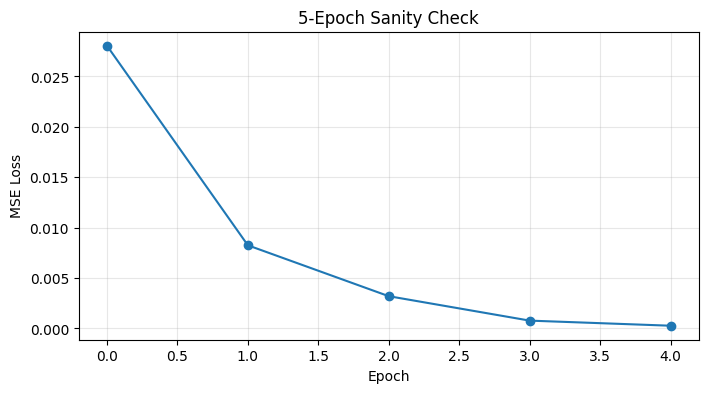

In [9]:
# quick 5-Epoch training to check
print("\n" + "="*60)
print("5-EPOCH SANITY TRAINING")
print("="*60)

torch.manual_seed(67)
model_sanity = CNNAutoencoder(latent_dim=64)
optimizer_sanity = create_optimizer(model_sanity, learning_rate=0.001)
criterion_sanity = create_loss_function()

losses = []
for epoch in range(5):
    model_sanity.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for images, labels in train_loader:
        normal_images = images[labels == 0]
        if normal_images.shape[0] == 0:
            continue
            
        reconstructed, _ = model_sanity(normal_images)
        loss = criterion_sanity(reconstructed, normal_images)
        
        optimizer_sanity.zero_grad()
        loss.backward()
        optimizer_sanity.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.6f}")

if losses[-1] < losses[0]:
    print(f"Loss decreased from {losses[0]:.6f} to {losses[-1]:.6f}")
else:
    print(f"Loss did not decrease significantly")

plt.figure(figsize=(8, 4))
plt.plot(losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('5-Epoch Sanity Check')
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# final verification summary
print("\n" + "="*60)
print("FINAL VERIFICATION SUMMARY")
print("="*60)

# re-declare everything fresh (in case of kernel restart)
data_dir = Path("../data/processed")
split_dir = data_dir / "splits"
required_files = ["train_files.json", "val_files.json", "test_files.json"]
missing_files = [f for f in required_files if not (split_dir / f).exists()]

# re-run shape check on CURRENT model
model = CNNAutoencoder(latent_dim=64)
dummy = torch.randn(1, 1, 4, 4)
reconstructed, _ = model(dummy)

# verify shapes match
shape_match = dummy.shape == reconstructed.shape

checks = {
    "Splits exist": len(missing_files) == 0,
    "Train normal-only": (train_labels == 1).sum() == 0,
    "Val normal-only": (val_labels == 1).sum() == 0,
    "Model shapes match": shape_match,
    "Gradients OK": not has_nan and not has_zero,
    "Loss decreases": losses[-1] < losses[0],
}

print("\nChecklist:")
all_passed = True
for check, passed in checks.items():
    status = "PASS" if passed else "✗ FAIL"
    print(f"{status}: {check}")
    if not passed:
        all_passed = False

print("\n" + "="*60)
if all_passed:
    print("ALL CHECKS PASSED! (YIPEE)")


FINAL VERIFICATION SUMMARY

Checklist:
PASS: Splits exist
PASS: Train normal-only
PASS: Val normal-only
PASS: Model shapes match
PASS: Gradients OK
PASS: Loss decreases

ALL CHECKS PASSED! (YIPEE)
